# Count min sketch with max heap (25pts)

In the class, we studied count-min sketch, an elegant algorithm to estimate the frequency of elements. Here we want to find the top-k frequent elements with one pass over an insert-only stream, using this algorithm. Note that to get top-k elements with only one pass, we must maintain an additional data structure, e.g., a heap, to store the current top-k frequent elements in the stream. 

Let $w$ be the width (num of columns) and $d$ be the depth (num of rows) of the count min sketch. The high-level idea of the algorithm is the following: 

1. Initialize a heap and a matrix of size $w\times d$. 

2. For each element $e$ coming from the stream, you should update the count min sketch matrix using d different hash functions (as taught in the class). Then, check if the heap size is already k. If no, insert a tuple (the count of $e$, e) into the heap; Else, replace the tuple of the least frequent element in the heap, say $h_0$, with a tuple of (estimated count of $e$, e), **if $e$ has an estimated frequency larger than $h_0$.**

Note the heap will have size at most k, and it stores the (estimated) top-k frequent elements. We need only $O(wd+k)$ words of memory to implement the whole idea. Please implement this algorithm as a class in the cell below.

### What is heap and how to use it in Python:

A heap is a specialized tree-based data structure which is essentially an almost complete tree that satisfies the heap property: in a max heap, for any given node C, if P is a parent node of C, then the key (the value) of P is greater than or equal to the key of C. A brief introduction can be found [here](https://en.wikipedia.org/wiki/Heap_(data_structure)).

In python, the most common implementation of heap can be found [here](https://docs.python.org/3/library/heapq.html). The heapq module implement min heap by storing the data in a list, and exposing all heap-operation APIs needed. You can also find examples of heapq [here](https://www.geeksforgeeks.org/heap-queue-or-heapq-in-python/).  Note when the data stored in the list are tuples, the first element of each tuple will be considered as the "key".



In [1]:
import heapq
import time
import matplotlib.pyplot as plt

class CountMinSketchHeap:
    """
    The CountMinSketchHeap class implements the Count-Min Sketch algorithm for approximate counting
        of item frequencies. It also maintain a heap of size k to store the top-k frequent elements.
    """
    
    def __init__(self, width, depth, k, hashfunc):
        """
        Following variables are initialized here.
        width: an integer representing the number of columns in the hash table.
        depth: an integer representing the number of rows in the hash table.
        k: the number of top frequent elements to store.
        hashfunc: a callable hash function.
        counts: a two-dimensional list representing the hash table.
        keys: a list that stores the current top k frequent elements.
        heap: a max heap of size at most k, it stores (count, elment) pairs of the top k frequent elements.
        hash_execution_time: an integer used to compute the efficiency of the hash function.
        """
        self.width = width
        self.depth = depth
        self.k = k
        self.hashfunc = hashfunc
        self.counts = [[0] * width for _ in range(depth)]
        self.keys = []
        self.heap = []
        self.hash_execution_time = 0
    
    def hash(self, key):
        """
        DONT CHANGE THIS!
        This function takes a key and generates in total self.depth hash values using self.depth 
            pairwise independent hash functions.
        """
        hashes = []
        st = time.time()
        for i in range(self.depth):
            h = self.hashfunc((i, key)) % self.width
            hashes.append(h)
        self.hash_execution_time += (time.time()-st)
        return hashes
    
    def update(self, key, count=1):
        """ This function updates both heap and count min sketch when we get a new element (key) from the stream.
        Please implement below. """
        hashes = self.hash(key)
        for i, h in enumerate(hashes):
            self.counts[i][h] += count
        
        estimate = self.query(key)
        if len(self.keys) < self.k:
            if key not in self.keys:
                self.keys.append(key)
                heapq.heappush(self.heap, (estimate, key))
            else: # if key is already stored, check whether to update the estimate
                for i, tup in enumerate(self.heap):
                    e, k = tup
                    if k == key and estimate > e:
                        self.heap[i] = (estimate, key)
                        heapq.heapify(self.heap)
        else: # cases when the heap is already full
            if key not in self.keys:
                least_count, least_key = self.heap[0]
                if estimate > least_count:
                    heapq.heapreplace(self.heap, (estimate, key))
                    self.keys.remove(least_key)
                    self.keys.append(key)
            else: # if key is already stored, check whether to update the estimate
                for i, tup in enumerate(self.heap):
                    e, k = tup
                    if k == key and estimate > e:
                        self.heap[i] = (estimate, key)
                        heapq.heapify(self.heap)

        
    def query(self, key):
        """ This function returns the estimated frequency of an element(key) via count min sketch.
        Please implement below. """
        hashes = self.hash(key)
        min_count = float('inf')
        for i, h in enumerate(hashes):
            min_count = min(min_count, self.counts[i][h])
        return min_count
    
    def topk(self):
        return sorted(self.heap, reverse=True)

Below is a set of hash functions implemented in hashlib package. 

In [2]:
# CODE FOR HASHING, DONT CHANGE

import hashlib
import mmh3

def md5_toint(key):
    a = hashlib.md5()
    a.update(bytes(str(key), 'utf-8'))
    return int.from_bytes(a.digest(),"big")

def sha256_toint(key):
    a = hashlib.sha256()
    a.update(bytes(str(key), 'utf-8'))
    return int.from_bytes(a.digest(),"big")

def blake2b_toint(key):
    a = hashlib.blake2b()
    a.update(bytes(str(key), 'utf-8'))
    return int.from_bytes(a.digest(),"big")

def murmur_toint(key):
    return mmh3.hash(str(key))

## Test and plot (5pts)

In the folder, we include a text file of the book "blue castle." The next cell use the CountMinSketchHeap implemented above to estimate the top 10 frequent words in this book. Set width=200, range depth in `[10,15,20,25]`, and try different hash functions listed above. The test code collects for each hash function two performance metrics:

- The execution time of the hash function, which equals to hash_execution_time (a variable defined in CountMinSketchHeap).

- The sum of the difference between estimated and real frequencies of top-10 words.

In the last cell, please generate one plot that contains a curve for each hash function, with x-axis representing the execution time and y-axis representing the sum of the difference. Please add markers and legends properly.

In [3]:
# TEST CODE, DONT CHANGE
def count_min_test(depth, hashf):
    c = CountMinSketchHeap(200, depth, 10, hashf)
    d = {}
    f = open("bluecastle.txt","r",encoding="UTF-8")
    for line in f:
        for word in line.split():
            if word not in d:
                d[word]=0
            d[word]+=1
            c.update(word)

    return sum([i[0] for i in c.topk()])-sum(sorted([d[i] for i in d])[-10:]), c.hash_execution_time

md5_time, md5_diff = [], []
sha256_time, sha256_diff = [], []
blake_time, blake_diff = [], []
murmur_time, murmur_diff = [], []
for depth in [10,15,20,25]:
    diff, timet = count_min_test(depth, md5_toint)
    md5_time.append(timet)
    md5_diff.append(diff)
    diff, timet = count_min_test(depth, sha256_toint)
    sha256_time.append(timet)
    sha256_diff.append(diff)
    diff, timet = count_min_test(depth, blake2b_toint)
    blake_time.append(timet)
    blake_diff.append(diff)
    diff, timet = count_min_test(depth, murmur_toint)
    murmur_time.append(timet)
    murmur_diff.append(diff)

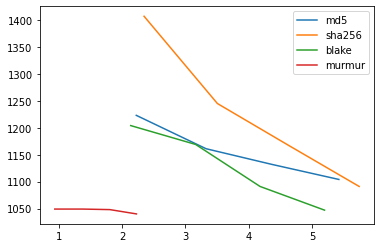

In [4]:
# Plot here
plt.plot(md5_time, md5_diff, label = 'md5')
plt.plot(sha256_time, sha256_diff, label = 'sha256')
plt.plot(blake_time, blake_diff, label = 'blake')
plt.plot(murmur_time, murmur_diff, label = 'murmur')
plt.legend()
plt.show()